<a href="https://colab.research.google.com/github/thmnguyen/team3-project-c/blob/main/Ragas_eva_Ollama_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code reads hallubench dataset csv file with answers column and evaluate the answers using RAGAS with Ollama-Llama 3 model local through Langchain Ollama. LLama 3.1 doesn't work (can't calculate faithfulness)

In [ ]:
# Installation
!pip install -q langchain langchain-community sentence-transformers datasets huggingface_hub ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.0/383.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Imports
import os
from datasets import Dataset
from langchain_community.llms import Ollama
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, answer_correctness
from langchain.embeddings import HuggingFaceEmbeddings
import pandas as pd

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAIBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAICommon has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ragas/metrics/__init__.py:4: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `

In [ ]:
# Install ollama: The Ollama API is now available at 127.0.0.1:11434
! curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
import subprocess
process = subprocess.Popen("ollama serve", shell=True)
# credit: https://stackoverflow.com/questions/78437376/run-ollama-run-llama3-in-colab-raise-err-error-could-not-connect-to-ollama

# download the Llama3 model for evaluation
!ollama pull llama3

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a...   0% ▕▏  13 MB/4.7 GB                  pulling manifes

In [ ]:
# Initialize Ollama with Llama 3
langchain_llm = Ollama(
    model="llama3",
    temperature=0.1,
    num_ctx=8096,  # Context window size
    num_thread=8,  # Number of threads to use
    verbose=True,
    timeout=None
)


In [ ]:
# Initialize HuggingFaceEmbeddings
langchain_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

<ipython-input-7-e2ee25c247b1>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  langchain_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public m

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Load your DataFrame (assuming you have a CSV file)
df = pd.read_csv('/content/halubench_short_2_answers_advancedRag_langchain_ollama_mistral.csv')

In [ ]:
# Preprocess the DataFrame
def preprocess_dataframe(df):
    df['ground_truth'] = df['ground_truth'].apply(
        lambda x: ' '.join(x) if isinstance(x, list) else str(x)
    )
    df['question'] = df['question'].astype(str)
    df['answer'] = df['answer'].astype(str)
    df['contexts'] = df['contexts'].apply(lambda x: [str(item) for item in x] if isinstance(x, list) else [str(x)])
    return df

df = preprocess_dataframe(df)

# Create the ragas_data dictionary
ragas_data = {
    "question": df['question'].tolist(),
    "contexts": df['contexts'].tolist(),
    "answer": df['answer'].tolist(),
    "ground_truth": df['ground_truth'].tolist()
}

# Convert to Dataset object
ragas_dataset_llm = Dataset.from_dict(ragas_data)


KeyError: 'ground_truth'

In [ ]:
# Run RAGAS evaluation
result_llm = evaluate(
    dataset=ragas_dataset_llm,
    metrics=[
        faithfulness,
        answer_relevancy,
        answer_correctness
    ],
    llm=langchain_llm,
    embeddings=langchain_embeddings
)

print(result_llm)

Evaluating:   0%|          | 0/180 [00:00<?, ?it/s]

{'faithfulness': 0.8167, 'answer_relevancy': 0.7832, 'answer_correctness': 0.5675}


In [ ]:
# Save the results to a CSV file
result_llm.to_pandas().to_csv('ragas_halubench_short_results_llamaCpp_colab_A100_2.csv', index=False)
result_llm_df=result_llm.to_pandas()
result_llm_df.head()

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,answer_correctness
0,Which team scored the longest field goal kick ...,[['Hoping to rebound from the road loss to the...,Lawrence Tynes kicked a 42-yard field goal fo...,"['Rams', 'second', 'Marc Bulger', 'Kevin Curtis']",0.333333,0.712968,0.522906
1,How many percent were not Irish?,"[['As of the census of 2000, there were 218,59...",The percentage of the population that was not...,87.1,0.000000,0.939102,0.402875
2,How many yards was the second longest field go...,[['Hoping to rebound from the road loss to the...,The second longest field goal of the first ha...,42,1.000000,0.926967,0.442153
3,How long was the last touchdown?,[['Hoping to rebound from their tough overtime...,The last touchdown was 15 yards.,18-yard,1.000000,0.804868,0.653606
4,How many in percent from the census weren't Ir...,"[['As of the census of 2000, there were 218,59...",Approximately 77.5% of the population were no...,87.1,1.000000,0.927663,0.388171


# Compare Evaluation

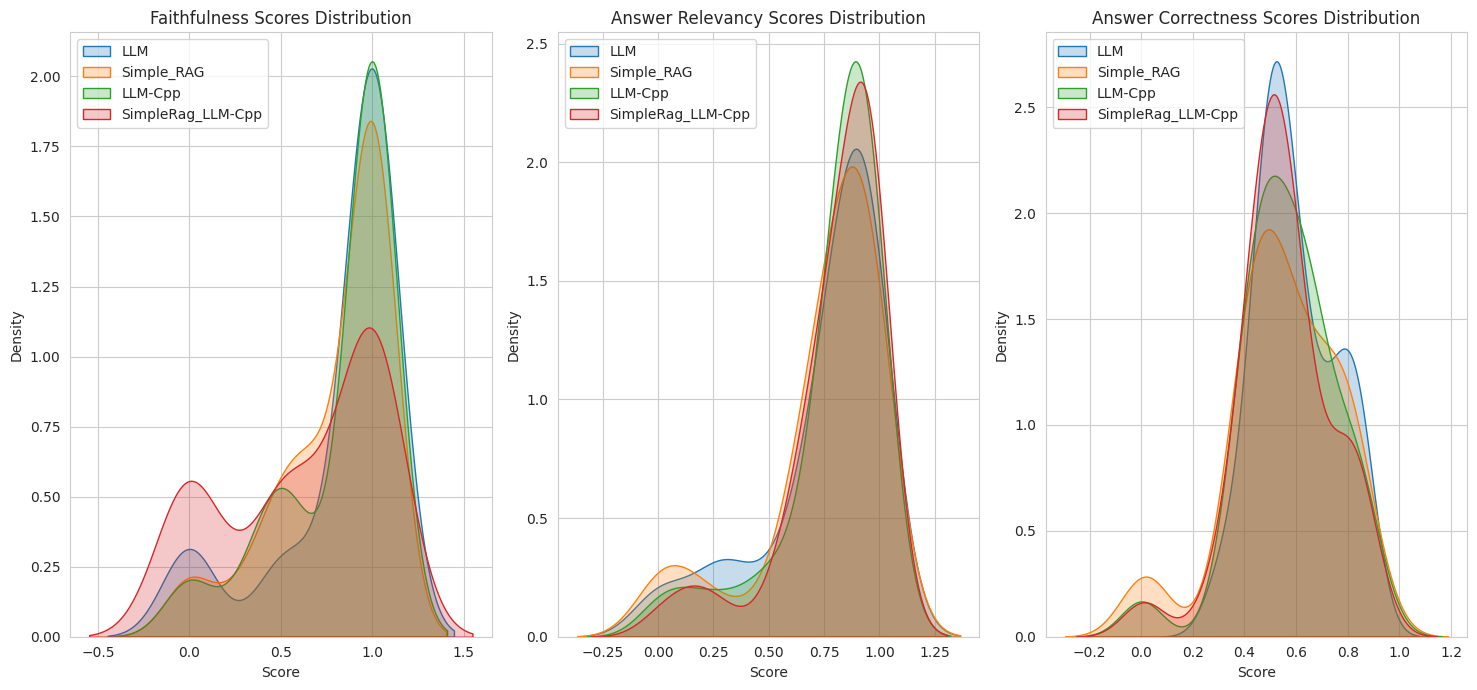

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'LLM': pd.read_csv('/content/ragas_halubench_short_results_langchain_ollama_colab_A100.csv'),
        'Simple_RAG': pd.read_csv('/content/ragas_halubench_short_results_simple_rag_ollama_A100.csv'),
        'LLM-Cpp': pd.read_csv('/content/ragas_halubench_short_results_llamaCpp_colab_A100.csv'),
        'SimpleRag_LLM-Cpp': pd.read_csv('/content/ragas_halubench_short_results_simpleRag_llamaCpp_colab_A100.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

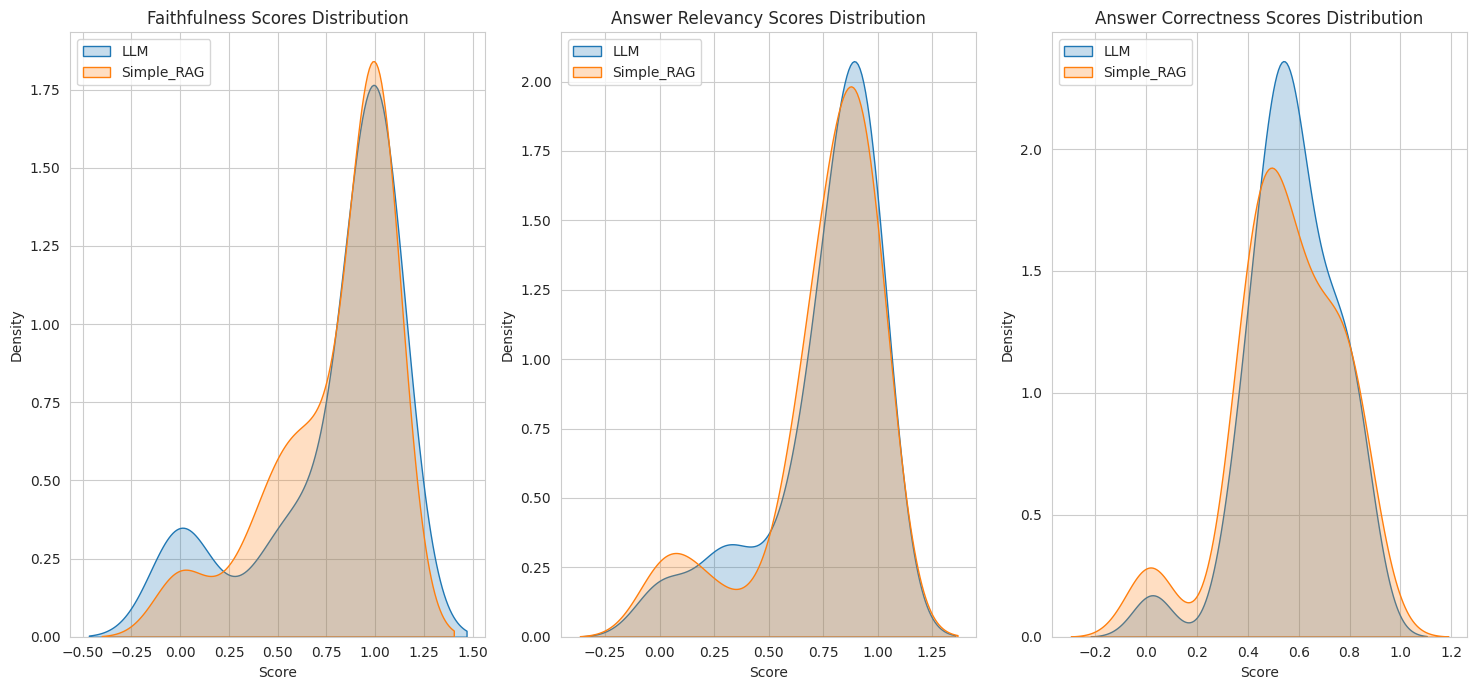

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'LLM': pd.read_csv('/content/ragas_halubench_short_results_langchain_ollama_colab_A100_2.csv'),
        'Simple_RAG': pd.read_csv('/content/ragas_halubench_short_results_simple_rag_ollama_A100.csv'),
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

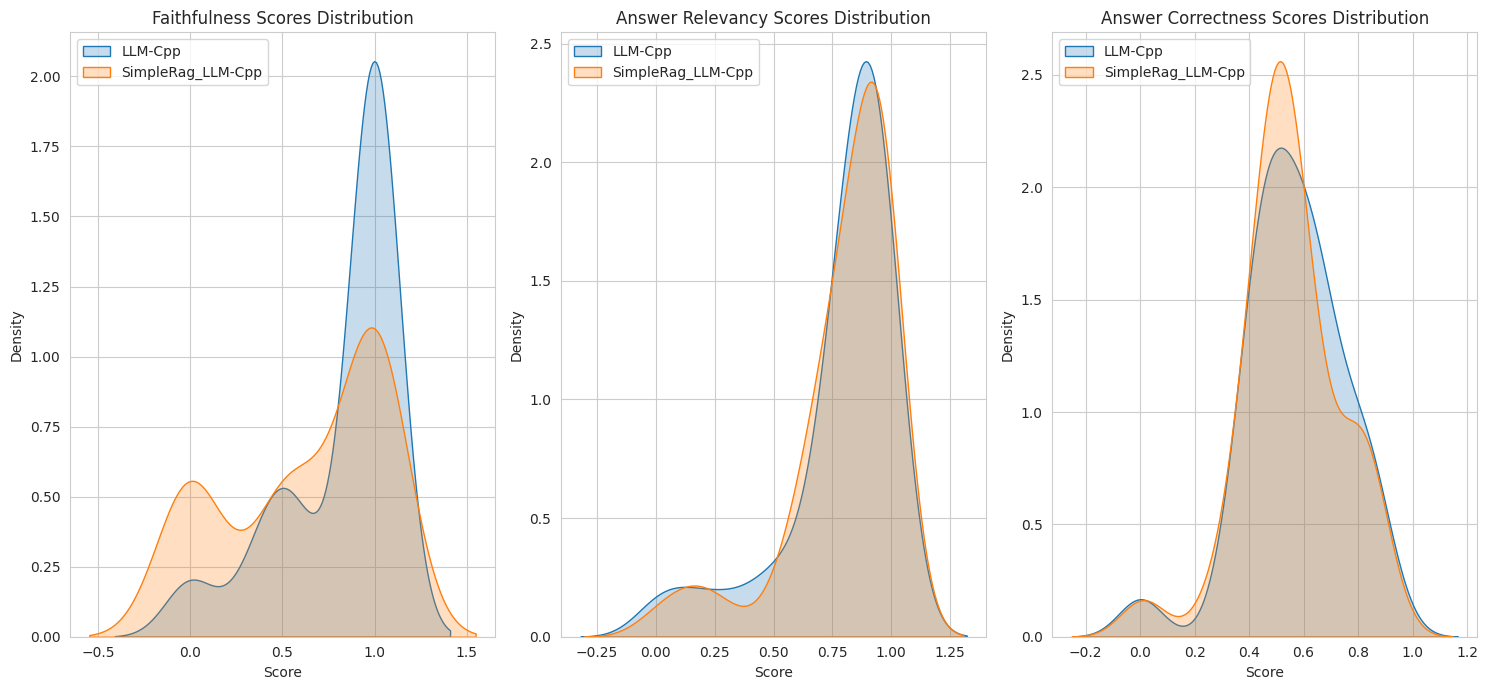

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'LLM-Cpp': pd.read_csv('/content/ragas_halubench_short_results_llamaCpp_colab_A100.csv'),
        'SimpleRag_LLM-Cpp': pd.read_csv('/content/ragas_halubench_short_results_simpleRag_llamaCpp_colab_A100.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

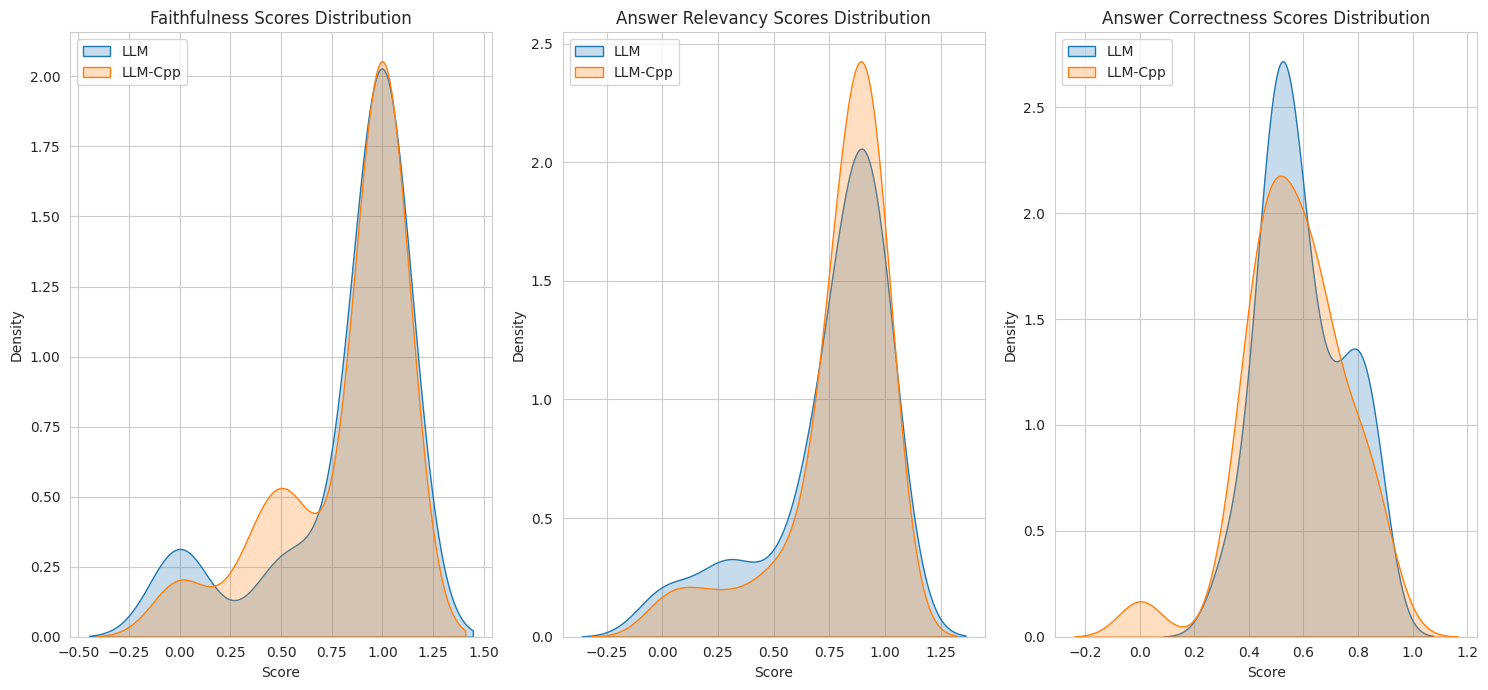

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'LLM': pd.read_csv('/content/ragas_halubench_short_results_langchain_ollama_colab_A100.csv'),
        'LLM-Cpp': pd.read_csv('/content/ragas_halubench_short_results_llamaCpp_colab_A100.csv'),
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

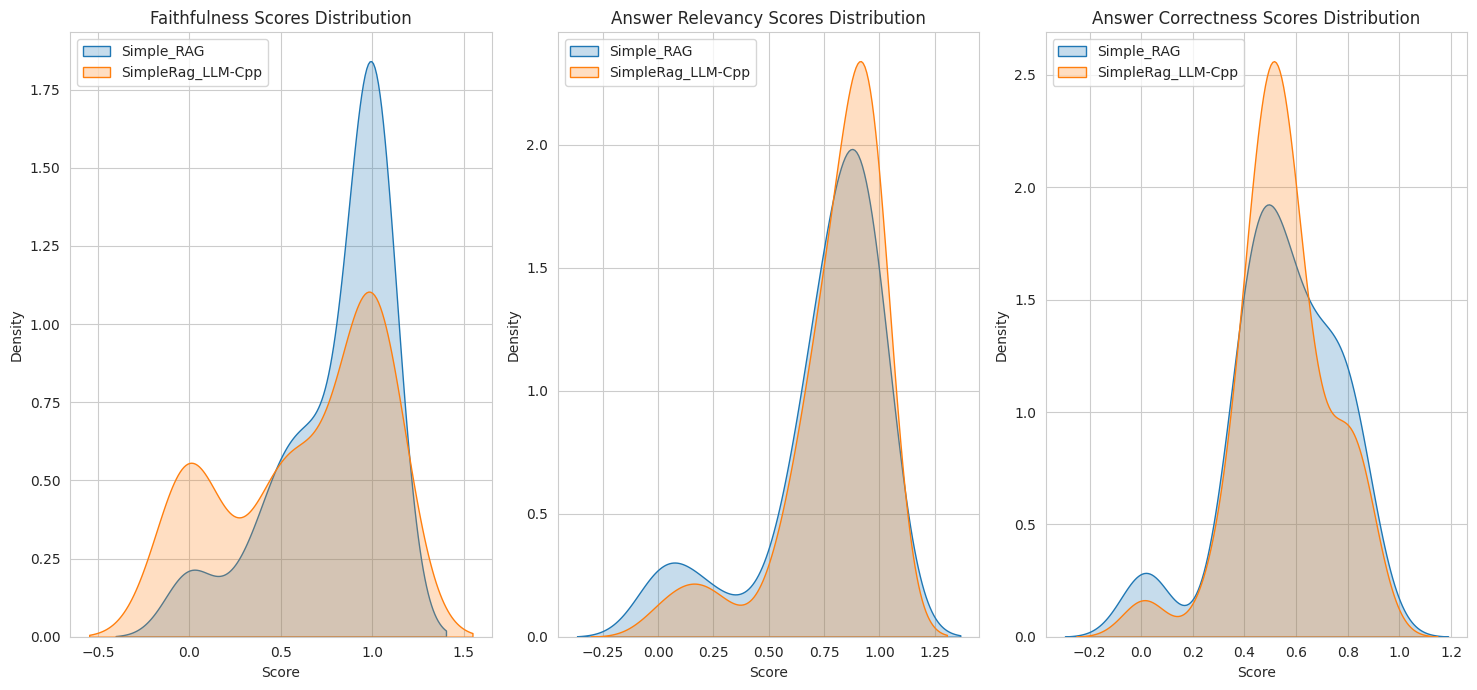

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'Simple_RAG': pd.read_csv('/content/ragas_halubench_short_results_simple_rag_ollama_A100.csv'),
        'SimpleRag_LLM-Cpp': pd.read_csv('/content/ragas_halubench_short_results_simpleRag_llamaCpp_colab_A100.csv')
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv_files():
    return {
        'LLM': pd.read_csv('/content/ragas_halubench_short_results_langchain_ollama_colab_A100_2.csv'),
        'Simple_RAG': pd.read_csv('/content/halubench_short_2_answers_advancedRag_langchain_ollama_mistral.csv'),
    }

def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def plot_metric(ax, dataframes, metric, title):
    for label, df in dataframes.items():
        # Convert the metric column to numeric, dropping any non-convertible values
        numeric_data = pd.to_numeric(df[metric], errors='coerce').dropna()
        if not numeric_data.empty:
            sns.kdeplot(data=numeric_data, ax=ax, label=label, fill=True)
        else:
            print(f"Warning: No valid numeric data for {label} in {metric}")
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

def main():
    sns.set_style("whitegrid")
    dataframes = read_csv_files()

    # Convert relevant columns to numeric
    metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness']
    for label in dataframes:
        dataframes[label] = convert_to_numeric(dataframes[label], metrics)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    titles = ['Faithfulness Scores', 'Answer Relevancy Scores', 'Answer Correctness Scores']

    for ax, metric, title in zip(axes, metrics, titles):
        plot_metric(ax, dataframes, metric, title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()